In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
from catalyst.runners import SupervisedRunner
from catalyst.callbacks import AccuracyCallback, EarlyStoppingCallback
from catalyst.utils import set_global_seed
import matplotlib.pyplot as plt
from typing import List, Dict
from sklearn.metrics import plot_confusion_matrix
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# internal imports:
from save_all_batch_metrics_callback import SaveAllBatchMetricsCallback
from model import MnistCNN, MnistSoftmaxRegression
from attacks import GradientSignAttacker
from utils import TorchToSklearnClassifierWrapper, DatasetWithTransforms


config = {
    "seed": 21,

    "data_folder": "data/",
    "logging_folder": "log/",

    "num_epochs": 10,
    "patience": 1,
    "batch_size": 512,

    "weight_decay": 0.001
}


set_global_seed(19)


def load_dataset(train_fraction=0.85):
    train_transforms = transforms.Compose(
        [transforms.RandomRotation(degrees=35), transforms.ToTensor()]
    )
    data_folder = config['data_folder']
    train = datasets.MNIST(data_folder, train=True, download=True)
    train_len = int(train_fraction * len(train))
    val_len = len(train) - train_len
    train, val = random_split(train, [train_len, val_len])
    train = DatasetWithTransforms(train, train_transforms, idx_to_apply=0)
    val = DatasetWithTransforms(val, transforms.ToTensor(), idx_to_apply=0)
    test = datasets.MNIST(data_folder, train=False, download=True, transform=transforms.ToTensor())
    return train, val, test


def plot_by_key(logging_list: List[Dict], key, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=[16, 9])
    ax.plot([entry[key] for entry in logging_list], **kwargs)
    return ax


def eval_runner(runner, eval_loader, metric_fn):
    metric_sum = 0
    for x, y in eval_loader:
        out = runner.predict_batch({"features": x})
        metric = metric_fn(y, out["logits"])
        current_batch_size = len(x)
        metric_sum += current_batch_size * metric
    return metric_sum / len(eval_loader.dataset)


def accuracy(y_true, logits):
    y_pred = torch.argmax(logits, dim=-1)
    return (y_true == y_pred).sum().to(torch.float) / len(y_true)


def separate_input_and_label(dataset, x_aggregate_fn=torch.stack, y_aggregate_fn=torch.tensor):
    X = []
    y = []
    for i in range(len(dataset)):
        x_example, y_example = dataset[i]
        X.append(x_example)
        y.append(y_example)
    return x_aggregate_fn(X), y_aggregate_fn(y)


# MNIST softmax regression

In [2]:
train, val, test = load_dataset()
train_loader = DataLoader(train, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test, batch_size=config["batch_size"])


model = MnistSoftmaxRegression()
loaders = {"train": train_loader, "valid": val_loader}
optimizer = torch.optim.Adam(model.parameters(), weight_decay=config["weight_decay"])
criterion = torch.nn.CrossEntropyLoss()
logging_dict = defaultdict(list)
callbacks = [
    EarlyStoppingCallback(patience=config["patience"]),
    AccuracyCallback(num_classes=10),
    SaveAllBatchMetricsCallback(logging_dict)
]


runner = SupervisedRunner(model)
runner.train(
    model=model,
    loaders=loaders,
    optimizer=optimizer,
    criterion=criterion,
    callbacks=callbacks,
    num_epochs=config["num_epochs"],
    logdir=config["logging_folder"]
)

[2020-10-18 05:54:11,518] 
1/10 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/10 * Epoch 1 (train): accuracy01=0.6657 | accuracy03=0.8736 | accuracy05=0.9410 | loss=1.3844
1/10 * Epoch 1 (valid): accuracy01=0.8338 | accuracy03=0.9613 | accuracy05=0.9876 | loss=0.8048
[2020-10-18 05:54:17,310] 
2/10 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/10 * Epoch 2 (train): accuracy01=0.7870 | accuracy03=0.9409 | accuracy05=0.9769 | loss=0.8381
2/10 * Epoch 2 (valid): accuracy01=0.8519 | accuracy03=0.9687 | accuracy05=0.9901 | loss=0.6192
[2020-10-18 05:54:23,109] 
3/10 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/10 * Epoch 3 (train): accuracy01=0.8101 | accuracy03=0.9499 | accuracy05=0.9812 | loss=0.7026
3/10 * Epoch 3 (valid): accuracy01=0.8596 | accuracy03=0.9711 | accuracy05=0.9904 | loss=0.5511
[2020-10-18 05:54:29,043] 
4/10 * Epoch 4 (_base): lr=0.0010 | momentum=0.9000
4/10 * Epoch 4 (train): accuracy01=0.8214 | accuracy03=0.9546 | accuracy05=0.9831 | loss=0.6448
4/10 * Epoch

Training curves:

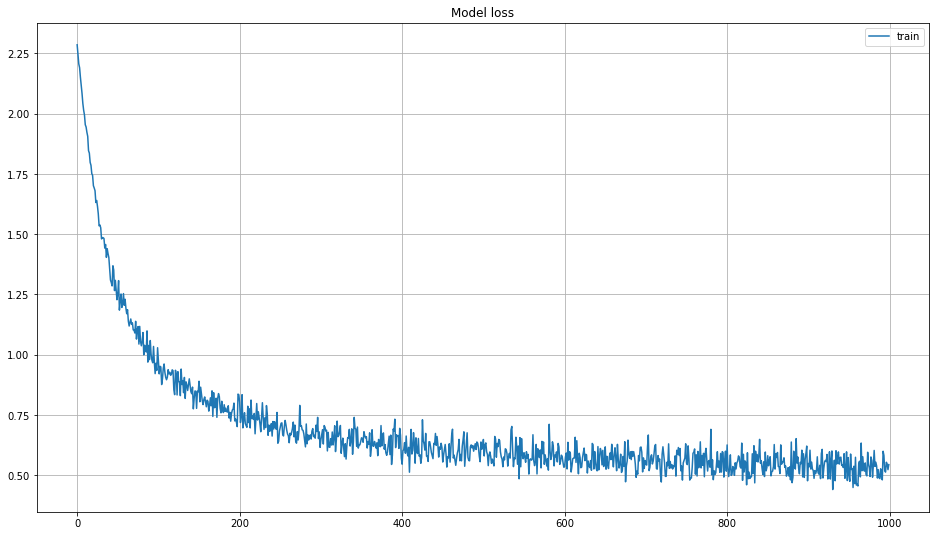

In [3]:
ax = plot_by_key(logging_dict["train"], "loss", label="train")
ax.set_title("Model loss")
ax.legend()
ax.grid()

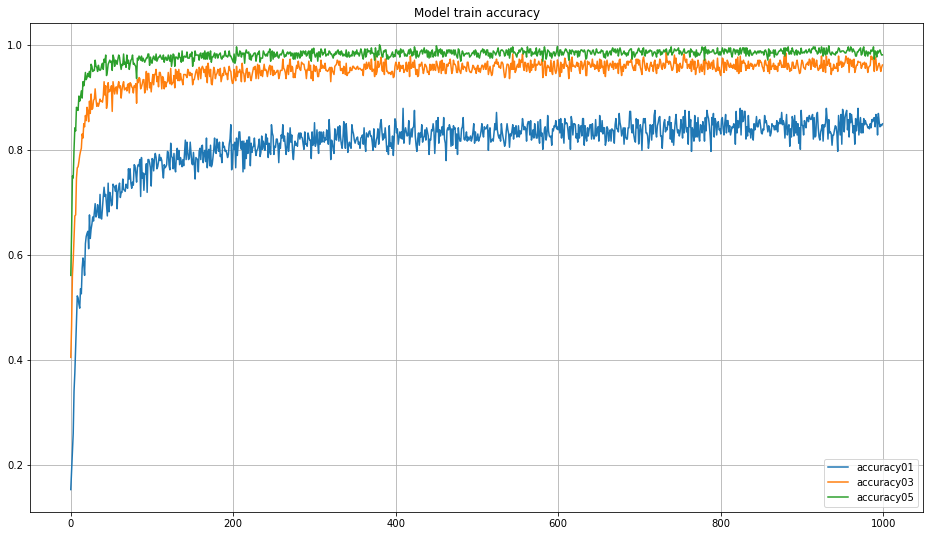

In [4]:
fig, ax = plt.subplots(figsize=[16, 9])
for suff in ["01", "03", "05"]:
    key = f"accuracy{suff}"
    plot_by_key(logging_dict["train"], key, ax=ax, label=key)
ax.set_title("Model train accuracy")
ax.legend()
ax.grid()

Evaluating model on test:

In [5]:
test_acc = eval_runner(runner, test_loader, accuracy)
print(f"Test accuracy is {test_acc.item():.3f}")

Test accuracy is 0.884


In [6]:
X_test, y_test = separate_input_and_label(test)
wrapped = TorchToSklearnClassifierWrapper(model.eval())

Confusion matrix for test dataset

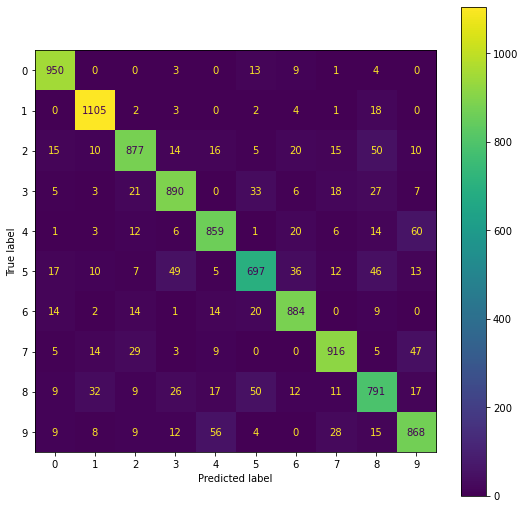

In [7]:
fig, ax = plt.subplots(figsize=[9, 9])
plot_confusion_matrix(wrapped, X_test, y_test, labels=list(range(10)), ax=ax)

## Gradient sign adversarial attack

In [8]:
attacker = GradientSignAttacker(
    model,
    loss_fn=torch.nn.functional.cross_entropy,
    input_shape=[1, 28, 28],
    n_classes=10
)


attacker.fit_adversaries(num_epochs=2000)

Let's produce adversarial examples for every class:

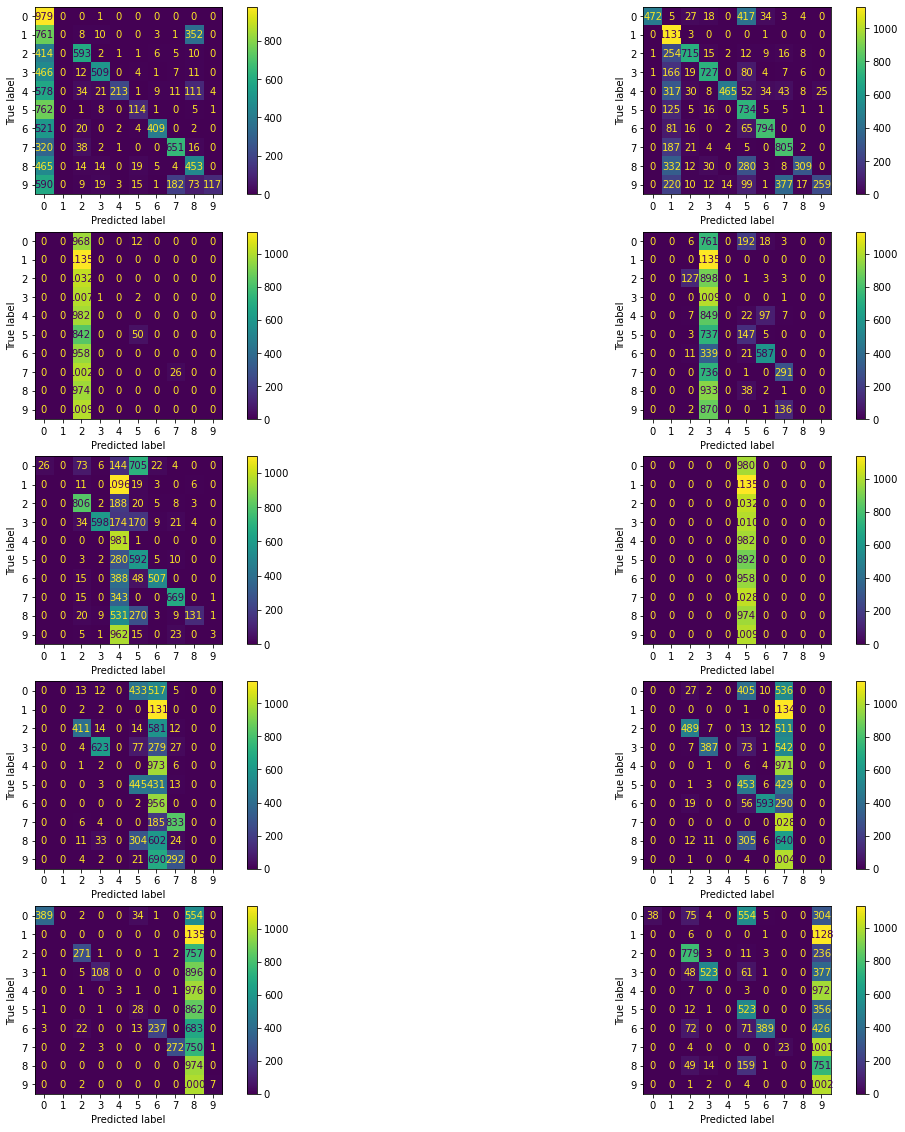

In [9]:
alpha = 0.7 # Weight of the original example in the corrupted sample

nrows, ncols = 5, 2
fig, axes = plt.subplots(figsize=[20, 20], nrows=nrows, ncols=ncols)
for i in range(10):
    row_idx = i // ncols
    col_idx = i % ncols
    ax = axes[row_idx][col_idx]
    corrupted = attacker.attack(X_test, class_idx=i, alpha=alpha)
    plot_confusion_matrix(wrapped, corrupted, y_test, labels=list(range(10)), ax=ax)

This way we can make our model confuse most of the examples with a specified class

But images themselves are still recognizible to a human eye

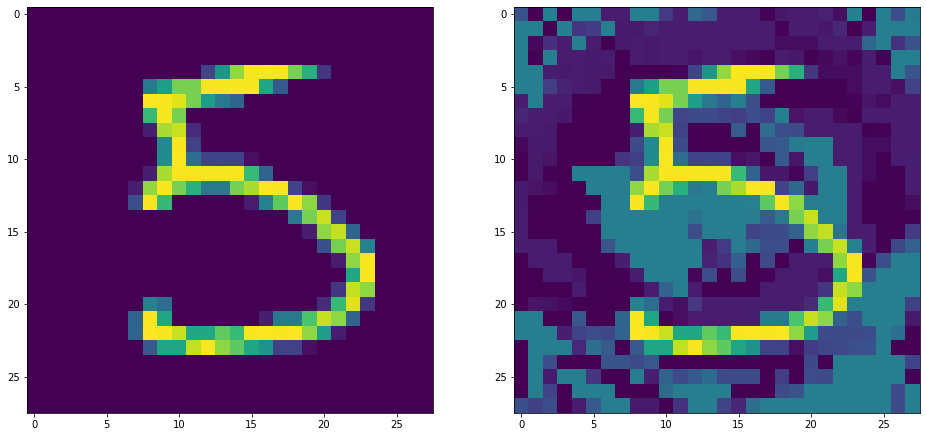

In [10]:
example_idx = 15
fig, axes = plt.subplots(figsize=[16, 8], nrows=1, ncols=2)
axes[0].imshow(X_test[example_idx].squeeze(0))
axes[1].imshow(corrupted[example_idx].squeeze(0).detach())

# Mnist CNN

Let's try to train and attack CNN. This model also relies on batch normalization and dropout (only in fc layers)

In [11]:
model = MnistCNN()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=config["weight_decay"])
criterion = torch.nn.CrossEntropyLoss()
logging_dict = defaultdict(list)
callbacks = [
    EarlyStoppingCallback(patience=config["patience"]),
    AccuracyCallback(num_classes=10),
    SaveAllBatchMetricsCallback(logging_dict)
]


runner = SupervisedRunner(model)
runner.train(
    model=model,
    loaders=loaders,
    optimizer=optimizer,
    criterion=criterion,
    callbacks=callbacks,
    num_epochs=config["num_epochs"],
    logdir=config["logging_folder"]
)

[2020-10-18 05:55:38,766] 
1/10 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/10 * Epoch 1 (train): accuracy01=0.8969 | accuracy03=0.9690 | accuracy05=0.9855 | loss=0.4484
1/10 * Epoch 1 (valid): accuracy01=0.9752 | accuracy03=0.9982 | accuracy05=0.9994 | loss=0.0983
[2020-10-18 05:56:05,517] 
2/10 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/10 * Epoch 2 (train): accuracy01=0.9701 | accuracy03=0.9960 | accuracy05=0.9990 | loss=0.1219
2/10 * Epoch 2 (valid): accuracy01=0.9836 | accuracy03=0.9984 | accuracy05=0.9996 | loss=0.0606
[2020-10-18 05:56:31,911] 
3/10 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/10 * Epoch 3 (train): accuracy01=0.9758 | accuracy03=0.9976 | accuracy05=0.9994 | loss=0.0872
3/10 * Epoch 3 (valid): accuracy01=0.9853 | accuracy03=0.9989 | accuracy05=0.9994 | loss=0.0496
[2020-10-18 05:56:58,518] 
4/10 * Epoch 4 (_base): lr=0.0010 | momentum=0.9000
4/10 * Epoch 4 (train): accuracy01=0.9795 | accuracy03=0.9983 | accuracy05=0.9995 | loss=0.0705
4/10 * Epoch

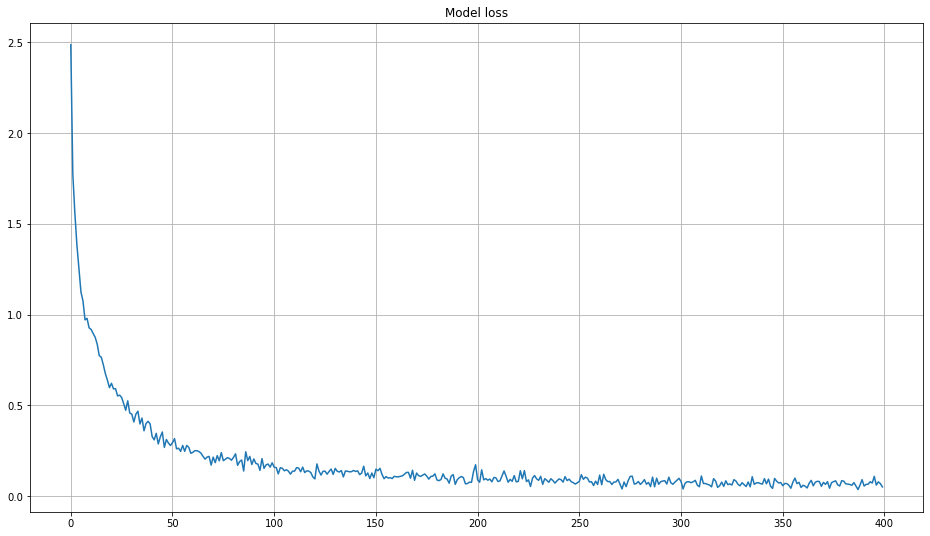

In [12]:
ax = plot_by_key(logging_dict["train"], "loss")
ax.set_title("Model loss")
ax.grid()

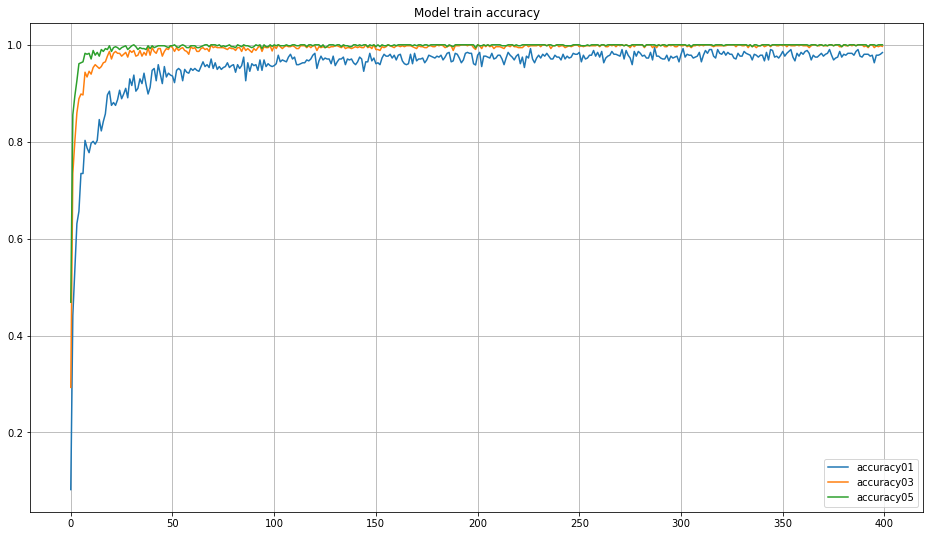

In [13]:
fig, ax = plt.subplots(figsize=[16, 9])
for suff in ["01", "03", "05"]:
    key = f"accuracy{suff}"
    plot_by_key(logging_dict["train"], key, ax=ax, label=key)
ax.set_title("Model train accuracy")
ax.legend()
ax.grid()

In [14]:
test_acc = eval_runner(runner, test_loader, accuracy)
print(f"Test accuracy is {test_acc.item():.3f}")

Test accuracy is 0.984


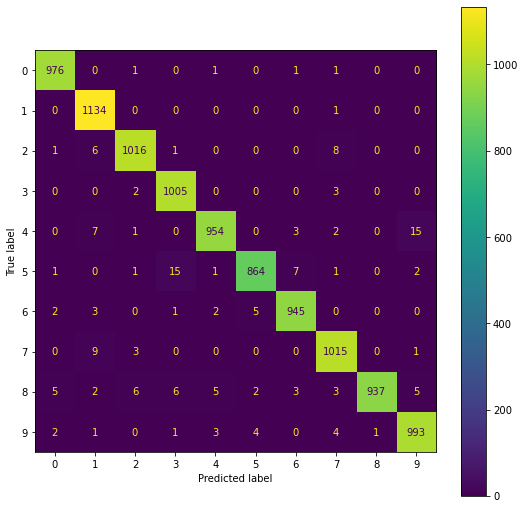

In [15]:
wrapped = TorchToSklearnClassifierWrapper(model.eval())


fig, ax = plt.subplots(figsize=[9, 9])
plot_confusion_matrix(wrapped, X_test, y_test, labels=list(range(10)), ax=ax)

In [16]:
attacker = GradientSignAttacker(
    model,
    loss_fn=torch.nn.functional.cross_entropy,
    input_shape=[1, 28, 28],
    n_classes=10
)

# More epochs are needed to generate good adverserial examples for CNN
attacker.fit_adversaries(num_epochs=5000)

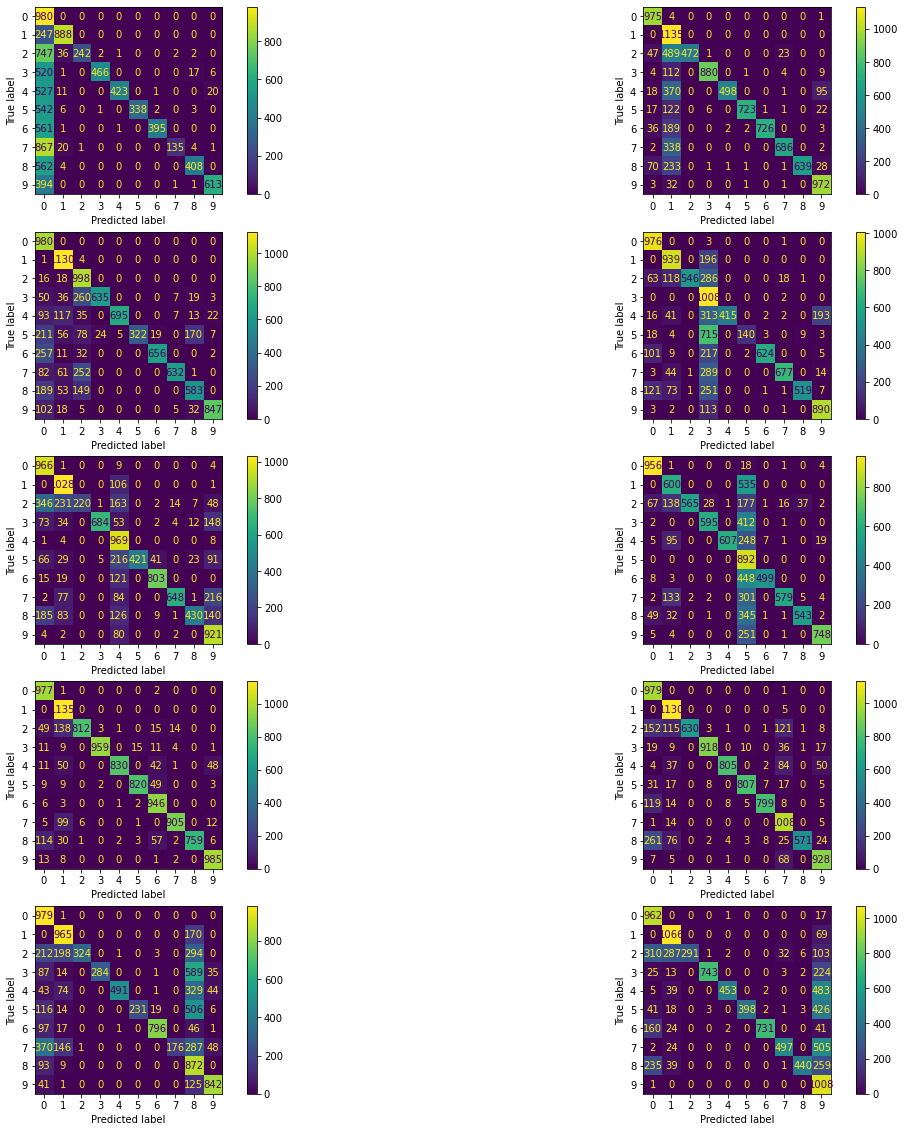

In [17]:
alpha = 0.7 # Weight of the original example in the corrupted sample

nrows, ncols = 5, 2
fig, axes = plt.subplots(figsize=[20, 20], nrows=nrows, ncols=ncols)
for i in range(10):
    row_idx = i // ncols
    col_idx = i % ncols
    ax = axes[row_idx][col_idx]
    corrupted = attacker.attack(X_test, class_idx=i, alpha=alpha)
    plot_confusion_matrix(wrapped, corrupted, y_test, labels=list(range(10)), ax=ax)

CNN with stronger regularization turned out to be more resilient to adversarial attacks than shallow model.